In [14]:
#assumptions that will break if we use MCTS for play traces in this code
#1. Turn wont be either 0 or 1
#2. Cant just copy the final two rows to extend round number to maxNoOfRounds

In [15]:
import pandas as pd
import pdb
import math
import matplotlib.cm as cm
import matplotlib.pyplot as plt
#from sklearn.manifold import MDS 
from sklearn.cluster import KMeans
import itertools
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 50)

In [16]:
#parameters for round robin tournament
NOOFPLAYERS = 2 #note, keep this fixed and dont change it
games_per_matchup = 25
self_play = True
agents = ['BMWG', 'DW']

In [17]:
data  = pd.read_csv("featureslogfile_BMWGvsDW_with_self_play.txt", sep = '\t')
print(data)

      GameID  Player  Round  Turn  CurrentScore  SCORE  SCORE_ADV  ORDINAL  \
0        2.0     0.0    0.0   0.0           3.0   0.06       0.00      0.5   
1        2.0     1.0    0.0   0.0           3.0   0.06       0.00      0.5   
2        2.0     0.0    0.0   1.0           3.0   0.06       0.00      0.5   
3        2.0     1.0    0.0   1.0           3.0   0.06       0.00      0.5   
4        2.0     0.0    1.0   0.0           3.0   0.06       0.00      0.5   
...      ...     ...    ...   ...           ...    ...        ...      ...   
8693   101.0     1.0   20.0   0.0          30.0   0.60       0.20      0.5   
8694   101.0     0.0   20.0   1.0          25.0   0.50      -0.32      1.0   
8695   101.0     1.0   20.0   1.0          33.0   0.66       0.32      0.5   
8696   101.0     0.0   21.0   0.0          31.0   0.62      -0.08      1.0   
8697   101.0     1.0   21.0   0.0          33.0   0.66       0.08      0.5   

      OUR_TURN  HAS_WON  ...  MINE  SENTRY  WITCH  ARTISAN  Pla

In [18]:
#define columns of interest 
card_types_BigMoneyWithGardens_vs_DoubleWitch = ['GARDENS', 'WITCH', 'CURSE', 'PROVINCE', 'DUCHY', 'ESTATE', 'GOLD', 'SILVER', 'COPPER']
cols = ['AgentName', 'Player', 'GameID', 'Round', 'CurrentScore']
cols = cols + card_types_BigMoneyWithGardens_vs_DoubleWitch

In [19]:
#we seem to have an issue with some cards having their number reduced, which shouldn't happen in our set-up
for card in card_types_BigMoneyWithGardens_vs_DoubleWitch:
    for game in data['GameID'].unique():
        for player in data['Player'].unique():
            card_evol = data[(data['GameID'] == game) & (data['Player'] == player) & (data['Turn'] == 1)][card]
            card_delta = card_evol - card_evol.shift(1)
            if card_delta.min() < 0:
                print("Issue with " + str(card) + " in game " + str(game) + " with player " + str(player))
                
#problem_trace = data[(data['GameID'] == 27) & (data['Player'] == 1)]['WITCH']
#print(problem_trace)

Issue with WITCH in game 27.0 with player 1.0
Issue with WITCH in game 30.0 with player 1.0
Issue with WITCH in game 38.0 with player 1.0
Issue with WITCH in game 43.0 with player 1.0
Issue with WITCH in game 77.0 with player 1.0
Issue with WITCH in game 78.0 with player 1.0
Issue with WITCH in game 79.0 with player 1.0
Issue with WITCH in game 84.0 with player 1.0
Issue with WITCH in game 85.0 with player 1.0
Issue with WITCH in game 88.0 with player 1.0
Issue with WITCH in game 92.0 with player 1.0
Issue with WITCH in game 99.0 with player 1.0
Issue with WITCH in game 100.0 with player 1.0


In [20]:
#label all games with corresponding agent names

#first generate match-ups
matchups = []
if self_play:
    for agent1 in agents:
        for agent2 in agents:
            matchups.append((agent1, agent2))
else:
    matchups = list(itertools.permutations(agents, 2))
    
#function to map gameID to match-up
def gameID_to_matchup(game_id, player_no, matchup_list, no_games_per_matchup, min_game_id):
    game_group = int((game_id - min_game_id)/no_games_per_matchup)
    matchup = matchup_list[game_group]
    agent1, agent2 = matchup
    if player_no == 0:
        return agent1
    else:
        return agent2
        
#add agent names to data set
min_GameID = data['GameID'].min()
data['AgentName'] = data.apply(lambda row: gameID_to_matchup(row['GameID'], row['Player'], matchups, games_per_matchup, min_GameID), axis = 1)                         

In [21]:
#we can only record events each turn so we need to use the final turn in each round for each player to determine their
#deck at the end of the round
print(data['Turn'].unique())
data = data[data['Turn'] == 1]

[0. 1.]


In [22]:
#all play taces in a single data frame
traces = data.loc[:, cols]
print(traces)

     AgentName  Player  GameID  Round  CurrentScore  GARDENS  WITCH  CURSE  \
2         BMWG     0.0     2.0    0.0           3.0      0.0    0.0    0.0   
3         BMWG     1.0     2.0    0.0           3.0      0.0    0.0    0.0   
6         BMWG     0.0     2.0    1.0           3.0      0.0    0.0    0.0   
7         BMWG     1.0     2.0    1.0           3.0      0.0    0.0    0.0   
10        BMWG     0.0     2.0    2.0           3.0      0.0    0.0    0.0   
...        ...     ...     ...    ...           ...      ...    ...    ...   
8687        DW     1.0   101.0   18.0          29.0      0.0    2.0    4.0   
8690        DW     0.0   101.0   19.0          24.0      0.0    2.0    6.0   
8691        DW     1.0   101.0   19.0          30.0      0.0    2.0    4.0   
8694        DW     0.0   101.0   20.0          25.0      0.0    2.0    6.0   
8695        DW     1.0   101.0   20.0          33.0      0.0    2.0    4.0   

      PROVINCE  DUCHY  ESTATE  GOLD  SILVER  COPPER  
2        

In [23]:
#we need to make sure all games have the same number of rounds in them
gameLengths = traces.groupby(['GameID'])['Round'].max()
maxNoOfRounds = int(gameLengths.max()) + 1 #round counter starts at zero
print(maxNoOfRounds)

31


In [24]:
def copy_final_deck_at_game_end(group, roundMax, noPlayers):
    #This function repeatedly copies the final decks of two players at the game end, so that the game is extended to 
    #have roundMax rounds
    final_round = int(group['Round'].max())
    if (roundMax-1) == final_round:
        #in this case we dont need to extend the play trace
        return group
    else:
        final_row_copy = pd.concat([group.iloc[-noPlayers:]] * ((roundMax-1) - final_round), ignore_index=True)
        #we need to update the Round counter so that every other row it increments by one
        final_row_copy['Round'] = [final_round + 1 + i // 2 for i in range(((roundMax-1) - final_round)*2)]
        return pd.concat([group, final_row_copy], ignore_index=True)

In [25]:
extended_traces = traces.groupby('GameID').apply(copy_final_deck_at_game_end, maxNoOfRounds, NOOFPLAYERS).reset_index(drop = True)
print(extended_traces)

     AgentName  Player  GameID  Round  CurrentScore  GARDENS  WITCH  CURSE  \
0         BMWG     0.0     2.0    0.0           3.0      0.0    0.0    0.0   
1         BMWG     1.0     2.0    0.0           3.0      0.0    0.0    0.0   
2         BMWG     0.0     2.0    1.0           3.0      0.0    0.0    0.0   
3         BMWG     1.0     2.0    1.0           3.0      0.0    0.0    0.0   
4         BMWG     0.0     2.0    2.0           3.0      0.0    0.0    0.0   
...        ...     ...     ...    ...           ...      ...    ...    ...   
6195        DW     1.0   101.0   28.0          33.0      0.0    2.0    4.0   
6196        DW     0.0   101.0   29.0          25.0      0.0    2.0    6.0   
6197        DW     1.0   101.0   29.0          33.0      0.0    2.0    4.0   
6198        DW     0.0   101.0   30.0          25.0      0.0    2.0    6.0   
6199        DW     1.0   101.0   30.0          33.0      0.0    2.0    4.0   

      PROVINCE  DUCHY  ESTATE  GOLD  SILVER  COPPER  
0        

In [26]:
#next we need to flatten this dataframe so that each trace is a single row.
#Note we drop the current score as we dont need it for now. We also drop the round label as it is redundant
#and it will get reintroduced when flattening through the revised column names
traces_tmp = extended_traces.drop(['CurrentScore', 'Round'], axis = 1)
cols = [card_types_BigMoneyWithGardens_vs_DoubleWitch[i] + "_R" + str(r) 
        for r in range(0, maxNoOfRounds) for i in range(0, len(card_types_BigMoneyWithGardens_vs_DoubleWitch))] 

extended_traces_flat = traces_tmp.groupby(['AgentName', 'Player', 'GameID']).apply(lambda df: df[card_types_BigMoneyWithGardens_vs_DoubleWitch].values.flatten())
extended_traces_flat = pd.DataFrame(extended_traces_flat, columns = ['Trace']).reset_index()
extended_traces_flat = pd.concat([extended_traces_flat[['AgentName', 'Player', 'GameID']], extended_traces_flat['Trace'].apply(pd.Series)], axis=1)
extended_traces_flat.columns = ['AgentName', 'Player', 'GameID'] + cols

#note we also add the name of the agent of the opponent for each trace (this is used later when grouping play traces)
extended_traces_flat['Opponent'] = extended_traces_flat.apply(lambda row: 1.0 if row['Player'] == 0.0 else 0.0, axis = 1)
extended_traces_flat['AgentNameOpponent'] = extended_traces_flat.apply(lambda row: gameID_to_matchup(row['GameID'], row['Opponent'], matchups, games_per_matchup, min_GameID), axis = 1)                                   

print(extended_traces_flat)

    AgentName  Player  GameID  GARDENS_R0  WITCH_R0  CURSE_R0  PROVINCE_R0  \
0        BMWG     0.0     2.0         0.0       0.0       0.0          0.0   
1        BMWG     0.0     3.0         0.0       0.0       0.0          0.0   
2        BMWG     0.0     4.0         0.0       0.0       0.0          0.0   
3        BMWG     0.0     5.0         0.0       0.0       0.0          0.0   
4        BMWG     0.0     6.0         0.0       0.0       0.0          0.0   
..        ...     ...     ...         ...       ...       ...          ...   
195        DW     1.0    97.0         0.0       0.0       0.0          0.0   
196        DW     1.0    98.0         0.0       1.0       0.0          0.0   
197        DW     1.0    99.0         0.0       0.0       0.0          0.0   
198        DW     1.0   100.0         0.0       0.0       0.0          0.0   
199        DW     1.0   101.0         0.0       0.0       0.0          0.0   

     DUCHY_R0  ESTATE_R0  GOLD_R0  ...  WITCH_R30  CURSE_R30  P

In [27]:
#comparing two distinct games we have:
#1. Game 1 player 1 - denoted by G1_P1
#2. Game 1 player 2 - denoted by G1_P2
#3. Game 2 player 1 - denoted by G2_P1
#4. Game 2 player 2 - denoted by G2_P2

#then the possible combinations of play traces to compare between two games are as follows:
#1. "G1_P1 (with opponent G1_P2)" versus "G2_P1 (with opponent G2_P2)"
#2. "G1_P1 (with opponent G1_P2)" versus "G2_P2 (with opponent G2_P1)"
#3. "G1_P2 (with opponent G1_P1)" versus "G2_P1 (with opponent G2_P2)"
#3. "G1_P2 (with opponent G1_P1)" versus "G2_P2 (with opponent G2_P1)"

#within a single game we can only compare the traces of player 1 and player 2

noOfGames = extended_traces_flat['GameID'].unique().size
noOfOffDiagGameCombos = int(noOfGames *(noOfGames -1)/2.0) 
noOfPairWiseDistances = 4 * noOfOffDiagGameCombos + noOfGames
print(noOfPairWiseDistances)

19900


In [28]:
#next we need to collect together all pairwise combinations of traces so that we can compute all distance measure pairs

# Step 1: Create a list of DataFrames for each 'off diagonal' combination of games
unique_values = extended_traces_flat['GameID'].unique()
offdiag_combinations = list(itertools.combinations(unique_values, 2))
diag_combos = [(i,i) for i in unique_values]
combos = offdiag_combinations + diag_combos

list_dfs = []
for combination in combos:
    #extract traces for each game ID and strategy combination
    GameID_1, GameID_2 = combination
    keys = []
    #label player numbers for clarity
    player1_game1 = 0
    player2_game1 = 1
    player1_game2 = 0
    player2_game2 = 1
    if GameID_1 != GameID_2:
        #define the four combinations of play traces we can compare between two 'off diagonal' games
        keys = [((GameID_1, player1_game1), (GameID_2, player1_game2)),
                ((GameID_1, player1_game1), (GameID_2, player2_game2)),
                ((GameID_1, player2_game1), (GameID_2, player1_game2)),
                ((GameID_1, player2_game1), (GameID_2, player2_game2))]
    else:
        keys = [((GameID_1, player1_game1), (GameID_1, player2_game1))]
             
    for key in keys:
        key1, key2 = key
        
        count= 0;
        df_inter = [];
        for game_player in [key1,key2]:
            count += 1
            tag = "_P" + str(count)
            game,player = game_player
        
            df = extended_traces_flat[(extended_traces_flat['GameID'] == game) & (extended_traces_flat['Player'] == player)]
            new_col_names = {old_col: old_col + tag for old_col in extended_traces_flat.columns}
            df = df.rename(columns=new_col_names)
            
            #store to prepare for concatenation
            df_inter.append(df)
            
        #next align play traces by concatenating 
        df_trace = pd.concat([df_inter[0], df_inter[1].set_index(df_inter[0].index)], axis = 1)
        
        #then add to list of dfs
        list_dfs.append(df_trace)
        
#finally we need to append togther all the datafarmes in our list
sym_trace_combos_flat = pd.concat(list_dfs, ignore_index=True)

In [29]:
#the no of rows in our symmetric trace combos should be given by noOfPairwiseDistances 
#and no columns should be given by the card types * no of rounds plus 5 (for player, player name, gameID, opponent and
#opponent name) all mulitplied by two, for the two players
print("Expected no rows: " + str(noOfPairWiseDistances))
print("Expected no of cols: " + str((len(card_types_BigMoneyWithGardens_vs_DoubleWitch)*maxNoOfRounds +5)*2))
sym_trace_combos_flat.shape

Expected no rows: 19900
Expected no of cols: 568


(19900, 568)

In [30]:
#next step is to calculate the distance between each pairwise play trace
def dist_measure(playTracePair, cardTypes, maxRounds, tag1, tag2):
    dist = 0
    for r in range(0, maxRounds):
        for card in cardTypes:
            col1 = card + "_R" + str(r) + tag1
            col2 = card + "_R" + str(r) + tag2
            dist += (playTracePair[col1]-playTracePair[col2])**2
    dist = math.sqrt(dist)
    return dist

In [31]:
#now compute all the pairwise trace distances
sym_trace_combos_flat['dist'] = sym_trace_combos_flat.apply(lambda row: dist_measure(row, card_types_BigMoneyWithGardens_vs_DoubleWitch,
                                                                                    maxNoOfRounds, "_P1", "_P2"), axis = 1)
print(sym_trace_combos_flat)

      AgentName_P1  Player_P1  GameID_P1  GARDENS_R0_P1  WITCH_R0_P1  \
0             BMWG        0.0        2.0            0.0          0.0   
1             BMWG        0.0        2.0            0.0          0.0   
2             BMWG        1.0        2.0            0.0          0.0   
3             BMWG        1.0        2.0            0.0          0.0   
4             BMWG        0.0        2.0            0.0          0.0   
...            ...        ...        ...            ...          ...   
19895           DW        0.0       97.0            0.0          0.0   
19896           DW        0.0       98.0            0.0          0.0   
19897           DW        0.0       99.0            0.0          0.0   
19898           DW        0.0      100.0            0.0          0.0   
19899           DW        0.0      101.0            0.0          0.0   

       CURSE_R0_P1  PROVINCE_R0_P1  DUCHY_R0_P1  ESTATE_R0_P1  GOLD_R0_P1  \
0              0.0             0.0          0.0           

In [32]:
#create a list groups by AgentName and AgentNameOpponent, where we also concatenate groups which have P1 to P2 symmetry
#For instance if we have traces of the form "BMWG (with opponent DW)" vs "DW (with opponent BM)" and also "DW (with opponent BM)" vs "BMWG (with opponent DW)"
#then group them together as they are equivalent 

#For some reason adding and deleting groups form a GroupBy object is difficult so instead we use a dictionary of dataframes
sym_trace_grouped = sym_trace_combos_flat.groupby(['AgentName_P1', 'AgentNameOpponent_P1', 'AgentName_P2', 'AgentNameOpponent_P2'])
sym_trace_grouped = {name: group for name, group in sym_trace_grouped}
print("Original number of groups: " + str(len(sym_trace_grouped.keys())))

removed_groups = []
new_groups = {}
for key1 in sym_trace_grouped:
    p1_1, p1_opp_1, p2_1, p2_opp_1 = key1
    if (key1 not in removed_groups):
        for key2 in sym_trace_grouped:
            if (key1 != key2):
                if (key2 not in removed_groups):
                    p1_2, p1_opp_2, p2_2, p2_opp_2 = key2
                    #now check for symmetry
                    if ((p1_1 == p2_2) & (p2_1 == p1_2) & (p1_opp_1 == p2_opp_2) & (p2_opp_1 == p1_opp_2)):
                        #concatenate dataframes to create a new group for a the dictionary
                        new_groups[key1] = pd.concat([sym_trace_grouped[key1],sym_trace_grouped[key2]])
                        #then add key2 to the list of removed groups
                        removed_groups.append(key2)
                        
#remove groups as needed from dictionary
for key in removed_groups:
    sym_trace_grouped.pop(key)

#add in new combined groups
for key in new_groups:
    sym_trace_grouped[key] = new_groups[key]
                        
print("Revised number of groups: " + str(len(sym_trace_grouped.keys())))                   

Original number of groups: 11
Revised number of groups: 10


In [33]:
#next we look at the average and standard deviation of distances between play traces grouped by the strategy 
#of the player and the opponent
mean_and_std = pd.DataFrame(columns = ['AgentName_P1','AgentNameOpponent_P1','AgentName_P2','AgentNameOpponent_P2',  
                        'Mean', 'Std', 'Count'])
for key in sym_trace_grouped:
    p1, opp1, p2, opp2 = key
    df_group = sym_trace_grouped[key]
    mean = round(df_group['dist'].mean(),1)
    std = round(df_group['dist'].std(),1)
    count = df_group['dist'].count()
    mean_and_std.loc[len(mean_and_std)] = [p1, opp1, p2, opp2, mean, std, count]

#order from high to low mean values
mean_and_std = mean_and_std.sort_values('Mean')

print(mean_and_std)

  AgentName_P1 AgentNameOpponent_P1 AgentName_P2 AgentNameOpponent_P2  Mean  \
0         BMWG                 BMWG         BMWG                 BMWG  12.7   
7           DW                 BMWG           DW                 BMWG  15.3   
4         BMWG                   DW         BMWG                   DW  18.8   
9           DW                   DW           DW                   DW  20.7   
2         BMWG                 BMWG           DW                 BMWG  28.7   
8           DW                 BMWG           DW                   DW  30.9   
6         BMWG                   DW           DW                   DW  32.8   
1         BMWG                 BMWG         BMWG                   DW  35.4   
3         BMWG                 BMWG           DW                   DW  39.5   
5         BMWG                   DW           DW                 BMWG  43.0   

   Std  Count  
0  6.1   1225  
7  5.6   1225  
4  6.9   1225  
9  6.9   1225  
2  6.9   2500  
8  6.4   2500  
6  7.8   2500  
1 

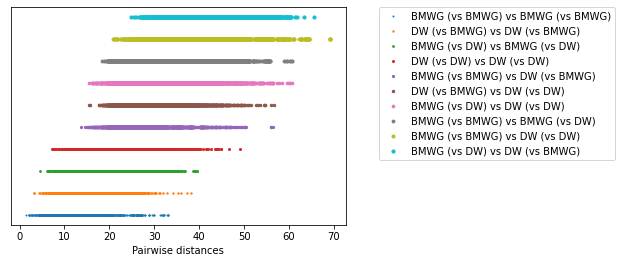

In [34]:
#plot distances along the real line and colour code
count = 0;
#note we use the ordering from the dataframe containing mean and stds so that we plot from high
#mean to low mean
for row in mean_and_std.iterrows():
    p1 = row[1]['AgentName_P1']
    opp1 = row[1]['AgentNameOpponent_P1']
    p2 = row[1]['AgentName_P2']
    opp2 = row[1]['AgentNameOpponent_P2']
    key = p1, opp1, p2, opp2 
    leg_label = p1 + " (vs " + opp1 + ") vs " + p2 + " (vs " + opp2 + ")"
    plt.scatter(sym_trace_grouped[key]['dist'], [count * 0.01] * sym_trace_grouped[key]['dist'].shape[0], s = count + 1, label = leg_label)
    count += 1
    
plt.yticks([])
plt.xlabel('Pairwise distances')
plt.legend(loc = (1.1,0.3))


In [35]:
#why do we have "BMWG (with opponent DW)" vs "DW (with opponent BM)" and also "DW (with opponent BM)" vs "BMWG (with opponent DW)"?
#this is because we have two games BM1 vs DW1 and BM2 vs DW2, then we have BM1 vs DW2 and also DW1 vs BM2, which looks symmetric
#and irrelevant but is actually a valid comparison. We also only have this symmetry when we are comparing two games, 
#within which each player has different strategies (but the same strategies across the two games), i.e A1 vs B1 and A2 vs B2, hence 
#why we only see the one extra group in the above results set
trace_set1 = sym_trace_combos_flat[(sym_trace_combos_flat['AgentName_P1'] == 'BMWG') & (sym_trace_combos_flat['AgentNameOpponent_P1'] == 'DW') 
                                  & (sym_trace_combos_flat['AgentName_P2'] == 'DW') & (sym_trace_combos_flat['AgentNameOpponent_P2'] == 'BMWG')]
trace_set2 = sym_trace_combos_flat[(sym_trace_combos_flat['AgentName_P1'] == 'DW') & (sym_trace_combos_flat['AgentNameOpponent_P1'] == 'BMWG') 
                                  & (sym_trace_combos_flat['AgentName_P2'] == 'BMWG') & (sym_trace_combos_flat['AgentNameOpponent_P2'] == 'DW')]

#now compare the set of games investigated
example1 = trace_set1[['GameID_P1', 'GameID_P2', 'AgentName_P1','AgentNameOpponent_P1', 'AgentName_P2','AgentNameOpponent_P2', 'dist']][0:5]
example2 = trace_set2[['GameID_P1', 'GameID_P2', 'AgentName_P1','AgentNameOpponent_P1', 'AgentName_P2','AgentNameOpponent_P2', 'dist']][0:5]

#in these examples we see different distance values showing that these are valid trace comparisons and not a double
#counting
print(example1)
print(example2)

      GameID_P1  GameID_P2 AgentName_P1 AgentNameOpponent_P1 AgentName_P2  \
8701       27.0       28.0         BMWG                   DW           DW   
8705       27.0       29.0         BMWG                   DW           DW   
8709       27.0       30.0         BMWG                   DW           DW   
8713       27.0       31.0         BMWG                   DW           DW   
8717       27.0       32.0         BMWG                   DW           DW   

     AgentNameOpponent_P2       dist  
8701                 BMWG  39.051248  
8705                 BMWG  39.420807  
8709                 BMWG  40.496913  
8713                 BMWG  45.475268  
8717                 BMWG  41.496988  
      GameID_P1  GameID_P2 AgentName_P1 AgentNameOpponent_P1 AgentName_P2  \
8702       27.0       28.0           DW                 BMWG         BMWG   
8706       27.0       29.0           DW                 BMWG         BMWG   
8710       27.0       30.0           DW                 BMWG         BMW

In [36]:
#next we compute the average traces for each combination of players and opponents, this 
#allows us to compare to the centroids computed by k-means clustering (note this is only 
#useful when we know what strategies are being employed by our AI agents or players, and 
#is used to sense check K-means in our base case scenarios)

flat_trace_tmp = extended_traces_flat.drop(['Player','Opponent','GameID'], axis = 1)
average_traces = flat_trace_tmp.groupby(['AgentName','AgentNameOpponent']).apply(lambda row: round(row.mean())).reset_index()
new_col_names = {old_col: old_col + '_avg' for old_col in average_traces.columns[2:]}
average_traces.rename(columns = new_col_names, inplace = True)
print(average_traces)

  AgentName AgentNameOpponent  GARDENS_R0_avg  WITCH_R0_avg  CURSE_R0_avg  \
0      BMWG              BMWG             0.0           0.0           0.0   
1      BMWG                DW             0.0           0.0           0.0   
2        DW              BMWG             0.0           0.0           0.0   
3        DW                DW             0.0           0.0           0.0   

   PROVINCE_R0_avg  DUCHY_R0_avg  ESTATE_R0_avg  GOLD_R0_avg  SILVER_R0_avg  \
0              0.0           0.0            3.0          0.0            1.0   
1              0.0           0.0            3.0          0.0            1.0   
2              0.0           0.0            3.0          0.0            1.0   
3              0.0           0.0            3.0          0.0            1.0   

   ...  COPPER_R29_avg  GARDENS_R30_avg  WITCH_R30_avg  CURSE_R30_avg  \
0  ...             7.0              1.0            0.0            0.0   
1  ...             7.0              3.0            0.0            7.0   

In [37]:
#next calculate the distance between every play trace and the average traces
distances_to_avgs_dict = {}
mean_and_std_to_avgs_list = []
for avg_trace_label in matchups:
    player, opp = avg_trace_label
    avg_trace = average_traces[(average_traces['AgentName'] == player) 
                               & (average_traces['AgentNameOpponent'] == opp)].drop(['AgentName','AgentNameOpponent'], axis = 1)
    avg_trace = pd.concat([avg_trace]*len(extended_traces_flat), ignore_index = True)
    avg_trace.reset_index()
    extended_traces_flat.reset_index()
    trace_pairs_to_avg = pd.concat([extended_traces_flat, avg_trace], axis = 1)
    
    #now we can compute the distance
    trace_pairs_to_avg['dist'] = trace_pairs_to_avg.apply(lambda row: dist_measure(row, card_types_BigMoneyWithGardens_vs_DoubleWitch,
                                                                                        maxNoOfRounds, "", "_avg"), axis = 1)
    trace_pairs_to_avg = trace_pairs_to_avg[['AgentName', 'AgentNameOpponent','dist']]
    distances_to_avgs_dict[avg_trace_label] = trace_pairs_to_avg
    
    #calculate averages and standard deviations
    results = round(trace_pairs_to_avg.groupby(['AgentName', 'AgentNameOpponent']).agg(['mean','std','count']),1).reset_index()
    results.columns = ['AgentName', 'AgentNameOpponent', 'Mean', 'Std', 'Count']
    avg_trace_label_as_str = "Avg. " + str(player) + " (vs " + str(opp) + ")"
    results['Average Trace'] = [avg_trace_label_as_str] * len(results)
    results['Average Trace Label'] = [(player,opp)] * len(results)
    results = results.reindex(columns=['AgentName', 'AgentNameOpponent', 'Average Trace','Mean', 'Std', 'Count', 'Average Trace Label'])
    mean_and_std_to_avgs_list.append(results)  

#concatenate mean and std results for each matchup
mean_and_std_to_avgs = pd.concat(mean_and_std_to_avgs_list)
mean_and_std_to_avgs = mean_and_std_to_avgs.sort_values('Mean')
print(mean_and_std_to_avgs)

  AgentName AgentNameOpponent        Average Trace  Mean  Std  Count  \
0      BMWG              BMWG  Avg. BMWG (vs BMWG)   9.4  4.0     50   
2        DW              BMWG    Avg. DW (vs BMWG)  11.1  3.9     50   
1      BMWG                DW    Avg. BMWG (vs DW)  13.8  4.3     50   
3        DW                DW      Avg. DW (vs DW)  14.9  4.7     50   
0      BMWG              BMWG    Avg. DW (vs BMWG)  26.2  5.0     50   
2        DW              BMWG  Avg. BMWG (vs BMWG)  26.7  5.4     50   
2        DW              BMWG      Avg. DW (vs DW)  27.7  3.1     50   
3        DW                DW    Avg. DW (vs BMWG)  28.9  5.6     50   
1      BMWG                DW      Avg. DW (vs DW)  29.9  5.7     50   
3        DW                DW    Avg. BMWG (vs DW)  30.5  5.8     50   
0      BMWG              BMWG    Avg. BMWG (vs DW)  32.8  2.2     50   
1      BMWG                DW  Avg. BMWG (vs BMWG)  34.3  7.3     50   
0      BMWG              BMWG      Avg. DW (vs DW)  37.4  5.5   

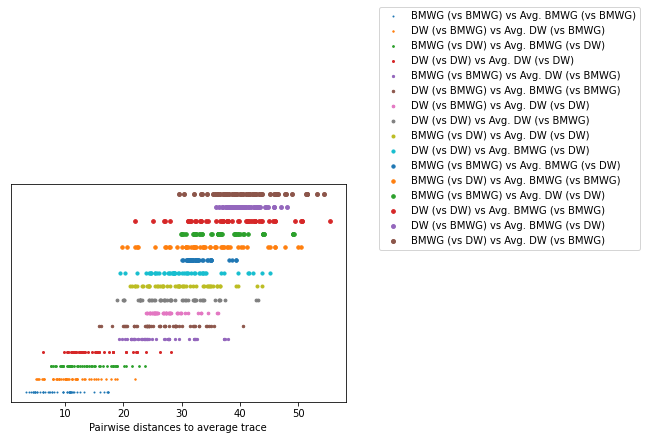

In [38]:
#plot distances to average traces along the real line and colour coded
count = 0;
#note we use the ordering from the dataframe containing mean and stds so that we plot from high
#mean to low mean
for row in mean_and_std_to_avgs.iterrows():
    player = row[1]['AgentName']
    opp = row[1]['AgentNameOpponent']
    avg_trace_label = row[1]['Average Trace Label']
    avg_trace_label_pl, avg_trace_label_opp = avg_trace_label
    df = distances_to_avgs_dict[avg_trace_label]
    df = df[(df['AgentName'] == player) & (df['AgentNameOpponent'] == opp)]
    leg_label = player + " (vs " + opp + ") vs Avg. " + avg_trace_label_pl + " (vs " + avg_trace_label_opp + ")"
    plt.scatter(df['dist'], [count * 0.01] * df['dist'].shape[0], s = count + 1, label = leg_label)
    count += 1
    
plt.yticks([])
plt.xlabel('Pairwise distances to average trace')
plt.legend(loc = (1.1,0.7))

In [39]:
#next we want to apply k-means clustering with (euclidean distance measure) on our set of traces to see if we can 
#identify BM and DW strategies without apriori knowledge of their existence. 
num_clusters = len(matchups)
trace_X = extended_traces_flat.drop(['AgentName','AgentNameOpponent','Player','Opponent','GameID'], axis = 1)
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', n_init= 'warn', max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='lloyd').fit(trace_X)

In [40]:
#add kmeans cluster classifications of traces to dataframe and see how that aligns with AI agent strategies
extended_traces_flat['ClusterID'] = kmeans.labels_
strat_vs_clusterid = extended_traces_flat[['AgentName', 'AgentNameOpponent','ClusterID']]
counts = strat_vs_clusterid.groupby(['AgentName', 'AgentNameOpponent','ClusterID']).size()
print(counts)

AgentName  AgentNameOpponent  ClusterID
BMWG       BMWG               0            50
           DW                 3            50
DW         BMWG               0             1
                              2            49
           DW                 0             1
                              1            47
                              2             2
dtype: int64


In [41]:
#look at how the cluster centers compare to our average traces
df_cluster_centres = pd.DataFrame(kmeans.cluster_centers_)
cols = [card_types_BigMoneyWithGardens_vs_DoubleWitch[i] + "_R" + str(r) for r in range(0, maxNoOfRounds) 
        for i in range(0, len(card_types_BigMoneyWithGardens_vs_DoubleWitch))]
df_cluster_centres.columns = cols
#round entires to nearest integer (inline with how we define our average traces)
df_cluster_centres = df_cluster_centres.round(0)
print(df_cluster_centres)

   GARDENS_R0  WITCH_R0  CURSE_R0  PROVINCE_R0  DUCHY_R0  ESTATE_R0  GOLD_R0  \
0         0.0       0.0       0.0          0.0       0.0        3.0      0.0   
1         0.0       0.0       0.0          0.0       0.0        3.0      0.0   
2         0.0       0.0       0.0          0.0       0.0        3.0      0.0   
3         0.0       0.0       0.0          0.0       0.0        3.0      0.0   

   SILVER_R0  COPPER_R0  GARDENS_R1  ...  COPPER_R29  GARDENS_R30  WITCH_R30  \
0        1.0        7.0         0.0  ...         7.0          1.0        0.0   
1        1.0        7.0         0.0  ...         7.0          0.0        2.0   
2        1.0        7.0         0.0  ...         7.0          0.0        2.0   
3        1.0        7.0         0.0  ...         7.0          3.0       -0.0   

   CURSE_R30  PROVINCE_R30  DUCHY_R30  ESTATE_R30  GOLD_R30  SILVER_R30  \
0        0.0           4.0        0.0         3.0       9.0         6.0   
1        5.0           4.0        2.0         4.

In [42]:
def deck_evol_comparison(trace1, trace2, tag1, tag2, cardTypes, maxRounds, label1 = 'Trace1', label2 = 'Trace2'):
    #look at evolution of number of cards of each type per round
    noCardTypes = len(cardTypes)
    noOfSubplotsInXDirection = 3
    noOfSubplotsInYDirection = 3
    fig, axs = plt.subplots(noOfSubplotsInXDirection, noOfSubplotsInYDirection)
    for i in range(0,3):
        for j in range(0,3):
            cardIndex = 3*j + i
            cardType = cardTypes[cardIndex]
            card_col_1 = [cardType + "_R" + str(r) + tag1 for r in range(0,maxRounds)]
            card_col_2 = [cardType + "_R" + str(r) + tag2 for r in range(0,maxRounds)]
            axs[i,j].plot(range(0,maxRounds), trace1[card_col_1].iloc[0], label = label1)
            axs[i,j].plot(range(0,maxRounds), trace2[card_col_2].iloc[0], label = label2)
            axs[i,j].set_title(cardType)
            axs[i,j].set_xlabel('Round')
            card_max = int(trace1[card_col_1].iloc[0].max())
            #pdb.set_trace()
            axs[i,j].set_ylim((0,card_max+2))
            axs[i,j].set_xticks(ticks = range(0, maxRounds,5))
            fig.tight_layout() 
    #add overal legend to figure
    axs[0,0].legend(loc = (4,0))

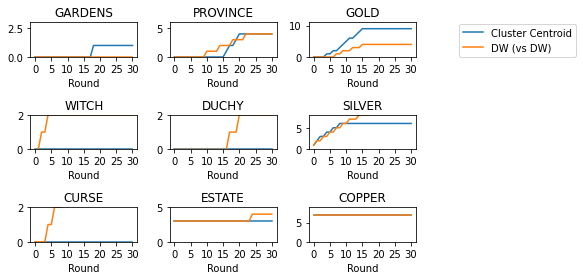

In [43]:
#compare centre with ClusterID zero to our average traces
cluster0centre = pd.DataFrame(df_cluster_centres.iloc[0]).transpose()
avg_trace_player = 'DW'
avg_trace_opp = 'DW'
avg_trace = average_traces[(average_traces['AgentName'] == avg_trace_player) 
                           & (average_traces['AgentNameOpponent'] == avg_trace_opp) ].drop(['AgentName','AgentNameOpponent'], axis =1)
deck_evol_comparison(cluster0centre, avg_trace, "", "_avg", card_types_BigMoneyWithGardens_vs_DoubleWitch
                    ,maxNoOfRounds, 'Cluster Centroid', avg_trace_player + " (vs " + avg_trace_opp + ")")

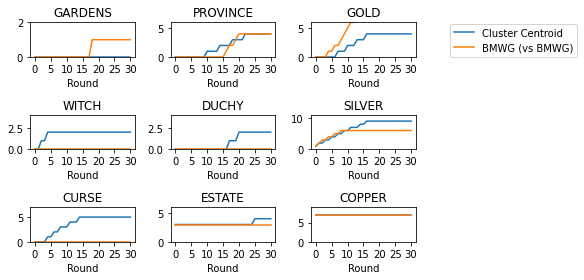

In [44]:
#compare centre with ClusterID one to our average traces
cluster1centre = pd.DataFrame(df_cluster_centres.iloc[1]).transpose()
avg_trace_player = 'BMWG'
avg_trace_opp = 'BMWG'
avg_trace = average_traces[(average_traces['AgentName'] == avg_trace_player) 
                           & (average_traces['AgentNameOpponent'] == avg_trace_opp) ].drop(['AgentName','AgentNameOpponent'], axis =1)
deck_evol_comparison(cluster1centre, avg_trace, "", "_avg", card_types_BigMoneyWithGardens_vs_DoubleWitch
                    ,maxNoOfRounds, 'Cluster Centroid', avg_trace_player + " (vs " + avg_trace_opp + ")")

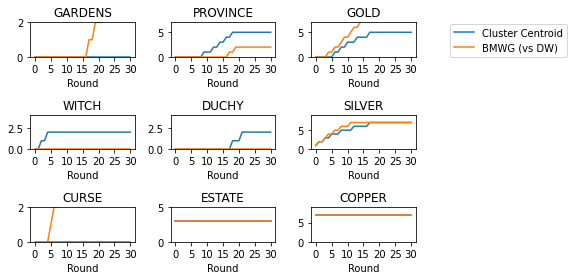

In [45]:
#compare centre with ClusterID two to our average traces
cluster2centre = pd.DataFrame(df_cluster_centres.iloc[2]).transpose()
avg_trace_player = 'BMWG'
avg_trace_opp = 'DW'
avg_trace = average_traces[(average_traces['AgentName'] == avg_trace_player) 
                           & (average_traces['AgentNameOpponent'] == avg_trace_opp) ].drop(['AgentName','AgentNameOpponent'], axis =1)
deck_evol_comparison(cluster2centre, avg_trace, "", "_avg", card_types_BigMoneyWithGardens_vs_DoubleWitch
                    ,maxNoOfRounds, 'Cluster Centroid', avg_trace_player + " (vs " + avg_trace_opp + ")")

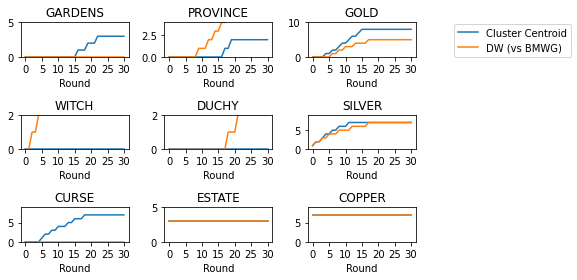

In [46]:
#compare centre with ClusterID three to our average traces
cluster3centre = pd.DataFrame(df_cluster_centres.iloc[3]).transpose()
avg_trace_player = 'DW'
avg_trace_opp = 'BMWG'
avg_trace = average_traces[(average_traces['AgentName'] == avg_trace_player) 
                           & (average_traces['AgentNameOpponent'] == avg_trace_opp) ].drop(['AgentName','AgentNameOpponent'], axis =1)
deck_evol_comparison(cluster3centre, avg_trace, "", "_avg", card_types_BigMoneyWithGardens_vs_DoubleWitch
                    ,maxNoOfRounds, 'Cluster Centroid', avg_trace_player + " (vs " + avg_trace_opp + ")")

For n_clusters = 2 The average silhouette_score is : 0.35464264161655934
For n_clusters = 3 The average silhouette_score is : 0.3556631892277652
For n_clusters = 4 The average silhouette_score is : 0.40988667816523217
For n_clusters = 5 The average silhouette_score is : 0.3792447430363387
For n_clusters = 6 The average silhouette_score is : 0.37169570070814417


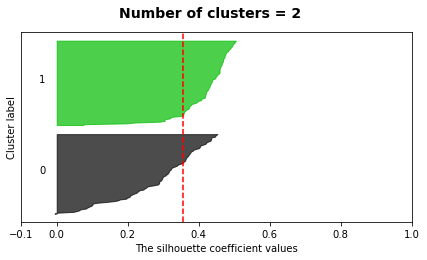

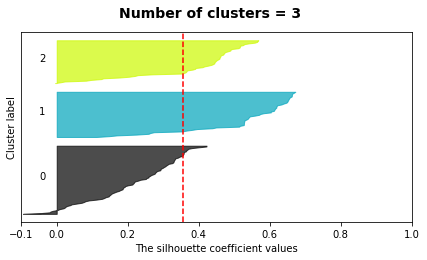

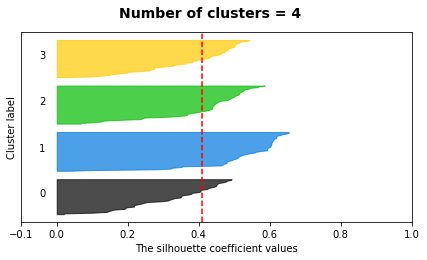

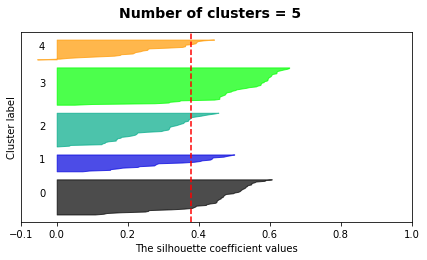

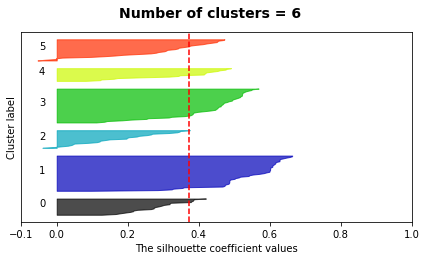

Text(0, 0.5, 'Silhouette Average')

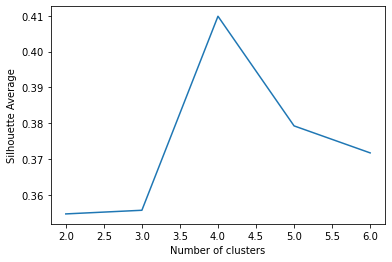

In [47]:
#next we consider three different methods for choosing the optimal number of clusters. If these dont perform well
#we will move onto the more complex approach of the gap statistic

#silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6]
silhouette_avg_list = []

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 1 columns
    fig, ax1 = plt.subplots(1,1)
    fig.set_size_inches(7, 3.5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(trace_X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init= 'warn', max_iter=300, tol=0.0001,
                    verbose=0, random_state= 10, copy_x=True, algorithm='lloyd')
    #cluster_labels = clusterer.fit_predict(X)
    cluster_labels = clusterer.fit_predict(trace_X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(trace_X, cluster_labels)
    silhouette_avg_list.append(silhouette_avg)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(trace_X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    #ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    plt.suptitle(
        #"Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        "Number of clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

#also we plot just the average silhouette values by cluster number
plt.plot(range_n_clusters, silhouette_avg_list)
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Average")



Text(0, 0.5, 'Scaled inertia')

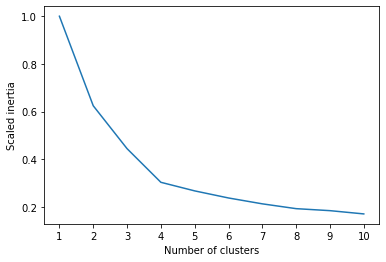

In [49]:
#inertia and elbow method
range_n_clusters = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
inertia_vals = []
for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init= 'warn', max_iter=300, tol=0.0001,
                    verbose=0, random_state= 10, copy_x=True, algorithm='lloyd')
    cluster_labels = clusterer.fit_predict(trace_X)
    inertia_vals.append(clusterer.inertia_)

#scale the inertia vals so that the first value is one
inertia_vals = np.array(inertia_vals)/inertia_vals[0]

#plot as a line plot
plt.plot(range_n_clusters, inertia_vals)
plt.xticks(range_n_clusters)
plt.xlabel("Number of clusters")
plt.ylabel("Scaled inertia")